# Lattice QCD ハンズオン
## LatticeQCD.jl でπ中間子の質量を計算してみよう。

- 2024/08/31　富谷昭夫 akio@yukawa.kyoto-u.ac.jp

このノートブックは、「[格子場の理論サマースクール2024](https://akio-tomiya.github.io/latticeschool2024/)」のハンズオンのために作成されました。
<font color="red">以下にも明記してありますが、実行部分では簡単な虫食いになっており、そのままでは動作しません。</font>
読みながらうまく動作させてください。

--- 
Julia およびLatticeQCD.jlインストールの手順は、以下のとおりです。

- Step1. Juliaを ```Juliaup``` https://github.com/JuliaLang/juliaup でいれる。
- Step2. JupyterNotebook を入れ、julia REPL からカーネルを```add IJulia```でいれる。
- Step3. LatticeQCD.jl を https://github.com/akio-tomiya/LatticeQCD.jl を参考に入れる (```add LatticeQCD```で入る)。

ここまで終わってれば次に進んでください。

--- 

Jupyternotebookの練習も兼ねて、次のセルを実行し、演習で必要なパッケージを入れておきましょう。
セル内にカーソルを合わせて「Shiftキー」と「エンターキー」を押すと実行できるはずです。

In [1]:
import Pkg; 
println("パッケージを追加します。")
Pkg.add("Plots")
Pkg.add("LaTeXStrings")
Pkg.add("Markdown")
Pkg.add("Dates")
Pkg.add("Printf")
println("最終行まで実行されました。全てインストール済なら「  No Changes to `~/hogehoge/Manifest.toml`」のように出ます。")

パッケージを追加します。


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


最終行まで実行されました。全てインストール済なら「  No Changes to `~/hogehoge/Manifest.toml`」のように出ます。


---
次に画面を移り、JuliaのREPLで以下を実行してください。

```
run_wizard()
```
すると ```my_parameters.toml``` というパラメータファイルを得ることになります。
パラメータファイルは、テキストエディタでの編集も、もちろん可能ですし、自分で書いても構いません。

- パラメータの作り方は、[ウィザードの使い方](https://www.dropbox.com/s/nlt3poou8gfd5li/wizardLQCD.pdf?dl=0)を参考に作ってください。
- ファイルを作るのが面倒な人は、[my_parameters.toml](https://www2.yukawa.kyoto-u.ac.jp/~akio.tomiya/filebox/school_handson/my_parameters.zip) においておきました、こちらをダウンロードし、このノートブックと同じディレクトリに入れてもらえれば同じように動作します。

以下では、

```
["Physical setting"]
L = [4, 4, 4, 24]
update_method = "Heatbath"
Nsteps = 200
"β" = 5.7

["System Control"]
logfile = "Heatbath_L04040424_beta5.7_quenched.txt"
verboselevel = 2
measurement_dir = "Heatbath_L04040424_beta5.7_quenched"
measurement_basedir = "./measurements"
log_dir = "./logs"
hasgradientflow = false

["Measurement set".measurement_methods.Pion_correlator]
methodname = "Pion_correlator"

    ["Measurement set".measurement_methods.Pion_correlator.fermion_parameters]
    Dirac_operator = "Wilson"

```
というクエンチ計算、熱浴法を使うことを前提とし、
パイ中間子の質量を測ってみます。

<font color="red">以下のセル以降、このJupyter notebook と同じ場所にパラメータファイルがあることを仮定して話を進めます。</font>

---

# 格子QCDの計算

ここから格子QCDの計算に入ります。
LatticeQCD.jl をロードします。

In [1]:
using LatticeQCD

--- 

<font color="red">以下のコードはこのままでは動作しません、虫食いになっています。XYZと書かれている部分は適切なコードを入れてください。</font>

パラメータファイル my_parameters.toml の中身を見てみます。

In [2]:
println(read("my_parameters.toml", String))

["HMC related"]
"Δτ" = 0.05
MDsteps = 20

["Physical setting(fermions)"]
Dirac_operator = "nothing"

["Physical setting"]
useOR = true
L = [4, 4, 4, 24]
Nthermalization = 0
update_method = "Heatbath"
numOR = 3
Nsteps = 200
"β" = 5.7

["System Control"]
logfile = "Heatbath_L04040424_beta5.7_quenched.txt"
verboselevel = 2
measurement_dir = "Heatbath_L04040424_beta5.7_quenched"
measurement_basedir = "./measurements"
log_dir = "./logs"
hasgradientflow = false

["Measurement set".measurement_methods.Pion_correlator]
methodname = "Pion_correlator"

    ["Measurement set".measurement_methods.Pion_correlator.fermion_parameters]
    Dirac_operator = "Wilson"

["Measurement set".measurement_methods.Polyakov_loop]
methodname = "Polyakov_loop"

["Measurement set".measurement_methods.Plaquette]
methodname = "Plaquette"

[gradientflow_measurements]
hasgradientflow = false

    [gradientflow_measurements.measurements_for_flow]



---

以下から実際のコード実行です。

---

<font color="red">以下のセルはコードの実行が行われるため、時間がかかります。</font>

In [4]:
# このセルを実行すると、実際にシミュレーションが走ります。
# 時間がかかります！ (m1 mac book air で440秒=7分ちょっと)
run_LQCD("my_parameters.toml") #パラメータファイルを指定して実行。

Dict{String, Any} with 2 entries:
  "Δτ"      => 0.05
  "MDsteps" => 20

inputfile: /Users/akio/Downloads/untitled folder/my_parameters.toml
[HMC related]
	
[Physical setting(fermions)]
	
[Physical setting]
	
[System Control]
	
[Measurement set]
[measurement_methods]
	
[gradientflow_measurements]
	
Heatbath will be used
# /Users/akio/Downloads/untitled folder
# 2024-09-12T11:27:43.602
Julia Version 1.10.2
Commit bd47eca2c8a (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 8 × Apple M1
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, apple-m1)
Threads: 1 default, 0 interactive, 1 GC (on 8 virtual cores)
Environment:
  JULIA_MPI_PATH = /opt/homebrew/Cellar/open-mpi/4.1.4_2
  JULIA_PROJECT = @.
  JULIA_NUM_THREADS = 

Heatbath update with even-odd method. Only plaquette action can be treated. Now β = 5.7
Hadron spectrum started
1 1
  0.755759 seconds (426.78 k allocations: 28.983 MiB, 81.03% compilation time)
Hadron spectrum: Inversion 1/12 is done
1 2
 

Dict{String, Any} with 1 entry:
  "Dirac_operator" => "nothing"

Dict{String, Any} with 7 entries:
  "useOR"           => true
  "Nthermalization" => 0
  "update_method"   => "Heatbath"
  "numOR"           => 3
  "Nsteps"          => 200
  "L"               => [4, 4, 4, 24]
  "β"               => 5.7

Dict{String, Any} with 6 entries:
  "hasgradientflow"     => false
  "logfile"             => "Heatbath_L04040424_beta5.7_quenched.txt"
  "verboselevel"        => 2
  "measurement_dir"     => "Heatbath_L04040424_beta5.7_quenched"
  "measurement_basedir" => "./measurements"
  "log_dir"             => "./logs"

Dict{String, Any} with 3 entries:
  "Pion_correlator" => Dict{String, Any}("fermion_parameters"=>Dict{String, Any…
  "Polyakov_loop"   => Dict{String, Any}("methodname"=>"Polyakov_loop")
  "Plaquette"       => Dict{String, Any}("methodname"=>"Plaquette")

Dict{String, Any} with 2 entries:
  "hasgradientflow"       => false
  "measurements_for_flow" => Dict{String, Any}()

0.5479097984877636

# $\pi$中間子の相関関数を描画

ここでは、$\pi$中間子の相関関数を描画してみます。
実際には、モンテカルロ法からくる統計誤差をジャックナイフ法などで
評価する必要がありますが、とりあえず中心値を見てみます
(中心値を計算するコードがあればジャックナイフ法を実装するのは難しくないので興味者ものは試してみてください)。

まず、補助的な関数を定義しておきます。


In [3]:
using Dates
using Printf

function ls_ltr(directory::String)
    # ディレクトリ内のファイル一覧を取得
    files = readdir(directory)
    
    # ファイル情報（タイムスタンプ、サイズ）を取得して、タイムスタンプでソート
    file_info = [(file, unix2datetime(stat(joinpath(directory, file)).mtime), stat(joinpath(directory, file)).size) for file in files]
    sorted_files = sort(file_info, by = x -> x[2])  # タイムスタンプでソート

    # 結果を表示
    for (file, mtime, size) in sorted_files
        @printf "%-20s %10d bytes %s\n" file size Dates.format(mtime, "yyyy-mm-dd HH:MM:SS")
    end
end

ls_ltr (generic function with 1 method)

In [4]:
# ディレクトリを見てみる ls -ltr 相当
ls_ltr("measurements/")


Heatbath_L04040424_beta5.7_quenched        160 bytes 2024-09-12 02:27:44
.DS_Store                  6148 bytes 2024-09-13 00:40:39


更にファイルを確認すると、

In [5]:
ls_ltr("measurements/Heatbath_L04040424_beta5.7_quenched/")
#;ls -ltr 

Pion_correlator.txt       10885 bytes 2024-09-12 02:35:07
Plaquette.txt              6086 bytes 2024-09-12 02:35:07
Polyakov_loop.txt         10605 bytes 2024-09-12 02:35:07


3つファイルがあるはずです。ここでは、Pion_correlator.txtを指定してみます。

Pion_correlator.txtの中身を見てみます。最後10行を見ると、

In [6]:
fname = "measurements/Heatbath_L04040424_beta5.7_quenched/Pion_correlator.txt";

In [7]:
# ファイル全体を読み込んで行ごとに分割
lines = readlines("measurements/Heatbath_L04040424_beta5.7_quenched/Pion_correlator.txt")

# 最後の 10 行を表示 (tail -n 10 と同じ)
println(join(last(lines, 10), "\n"))


 139.04621111324613 1.0797610182097874 0.26419403740532554 0.0446034191079106 0.011266816933202806 0.002662053236684579 0.0005827036922492386 0.00015067589708806523 3.6423686739692436e-5 1.0712935474292959e-5 3.097846341092289e-6 1.1135105011309169e-6 2.6316572199784773e-7 3.9986918393380845e-7 1.5989608802239833e-6 8.04056078654367e-6 2.9485808353281206e-5 0.00018782898936566957 0.0006918494483918539 0.003141352763034348 0.012816354875409027 0.05856416036579575 0.24659829122554605 0.726184675898592  #pioncorrelator
 138.72838950778663 0.7910962294159757 0.31109682375048614 0.07467879774856102 0.021412011470686842 0.006745050098406229 0.0017790228755031707 0.0005199340402332395 0.00016353421230563283 5.542740831939524e-5 1.414172034781564e-5 3.51785822357365e-6 6.728473679144047e-7 2.7262975026164e-7 4.929635762793107e-7 2.092737053590124e-6 1.1014633318324876e-5 6.512640116003829e-5 0.0002761730643989568 0.00127098609232967 0.007633769678123072 0.035571329849499775 0.2199453840896204 

$G(t)$をπ中間子の相関関数として、「トラジェクトリ番号　$G(t=0)$ $G(t=1)$ ... $G(t=23)$」 の順に並んでいます。これを解析していきます。

$Nt = 24$ で、かつ熱化で捨てる個数を11個とします。

In [8]:
Nt = 24;
N_therm = 11; # モンテカルロの熱化、どれくらい捨てるか。

In [9]:
values= []
for u in readlines(fname)
    if u[1] == '#'
    else
        value = parse.(Float64, split(u)[1:Nt] )
        push!(values,value)
    end

end
# values

In [10]:
pions = zeros(Nt,length(values))
for i = 1:length(values)
    pions[1:Nt,i] = values[i][1:Nt]
end
size(pions)
Ndata = size(pions)[2]
println("総データ数は$(Ndata)個。 熱化の分$(N_therm)個だけ放棄するので、$(Ndata-N_therm)個だけ解析します。")

総データ数は21個。 熱化の分11個だけ放棄するので、10個だけ解析します。


ここからπ中間子の相関関数を図示するために、Plots をロードする。

In [11]:
using Plots

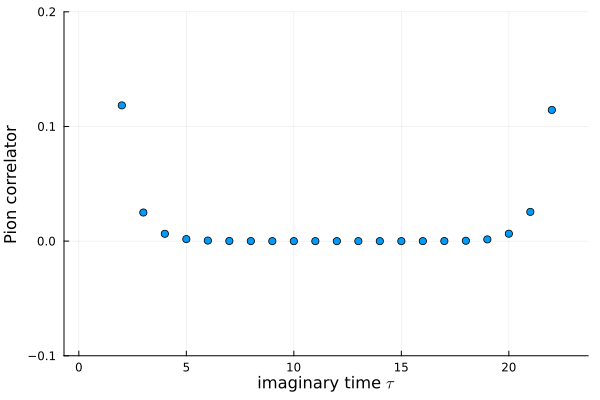

In [12]:
mean_value_pions = zeros(Nt)
for i = N_therm:length(values)
    mean_value_pions[1:Nt] += pions[1:Nt,i]
end
mean_value_pions/=Ndata
mean_value_pions
ts = collect(0:Nt-1)
scatter(ts,mean_value_pions,xlabel=raw"imaginary time $\tau$",ylabel="Pion correlator",label=nothing,yrange=(-0.1,0.2))

相関関数は、虚時間形式なので虚時間発展を考えると$\textrm{e}^{-H \tau} \sim \textrm{e}^{- m_\pi \tau}$ となりそうですが
(最小固有値が一番長く寄与をのこすからです、大きな固有値は最初に消えていきます。
今の場合にはπ中間子の質量がそれに相当します)、
実際には周期的境界条件の影響で反対側からの寄与があるため

$$
\langle \pi(\tau)\pi(0) \rangle \sim \cosh(m (\tau-T/2))
$$

を得ます。$y$軸を対数表示すると以下のようになります。

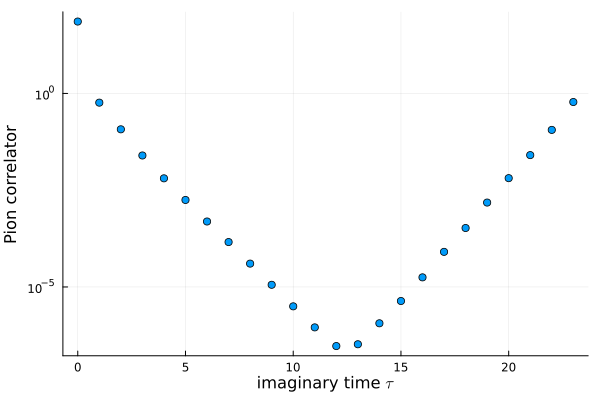

In [13]:
scatter(ts,mean_value_pions,xlabel=raw"imaginary time $\tau$",ylabel="Pion correlator",yscale=:log10,label=nothing)

今の場合、一番小さい固有値 (長距離)で効いてくる減衰率がパイ中間子の質量になるので、以下のように質量を推定できます。

In [14]:
meffs = []
ts2 = []
for t=1:div(Nt,2)
    meff = -log(mean_value_pions[t+1]/mean_value_pions[t])
    println("$(t-1) $meff")
    push!(ts2,t-1)
    push!(meffs,meff)
end

0 4.82606433836034
1 1.586924210599467
2 1.5567847174710714
3 1.359422217165435
4 1.2868648766503503
5 1.2820195551758056
6 1.2234917771588376
7 1.2820693175220486
8 1.2604294575671238
9 1.28229473259596
10 1.2519246070059782
11 1.1115371560492464


これは以下のように図示できます。

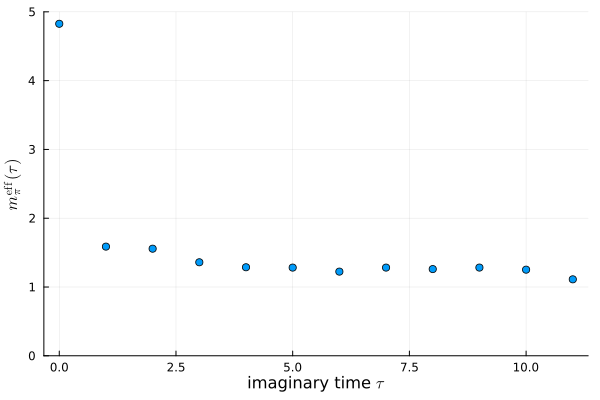

In [15]:
scatter(ts2,meffs,xlabel=raw"imaginary time $\tau$",ylabel=raw"$m^\mathrm{eff}_\pi(\tau)$",label=nothing,yrange=(0,5))

有効質量が(ほぼ)一定になってるところを取り出します。本当はエラーバー込みで評価する必要がありますが、
詳しい解析は割愛する。まず色々とロードします。

In [16]:
using Statistics
using LaTeXStrings
using Markdown
# もし 
# ArgumentError: Package LaTeXStrings not found in current path.
# - Run `import Pkg; Pkg.add("LaTeXStrings")` to install the LaTeXStrings package.
# の様なエラーが出ればターミナルでJulia を呼び出して、必要なパッケージをインストールつまり
# pkg> add LaTeXStrings
# として戻って来てください。

In [17]:
m_pi = mean(meffs[3:12])
pi_mass_str_lat = L"今のセットアップで $\pi$ 中間子の質量はおよそ $am_{\pi} = $" * "$(round(m_pi, digits=4))" * " です。"

# Markdownを使って表示
display(Markdown.MD(pi_mass_str_lat))

"今のセットアップで \$\\pi\$ 中間子の質量はおよそ \$am_{\\pi} = \$1.2897 です。"


これを格子間隔$a$を取り除いて物理的なスケールとして表すなら以下のようにします。
格子間隔は、結合定数$\beta = 6/g^2$の関数であることを使います。

# 現実と比較する

もし、物理的なスケール(MeVなど)に直したければ、$\beta$関数を用いれば良いです。
$\beta$関数を使うと結合定数$g$の情報をカットオフスケール$1/a$ [MeV]に焼き直すことができます。
($\beta$関数と$\beta = 6/g^2$の$\beta$は関係がない偶然の文字の衝突です、念の為)

[hep-lat/9806005](https://arxiv.org/abs/hep-lat/9806005) の(2.18)によると、クエンチ近似の範囲内で、格子間隔$a$と$\beta = 6/g^2$の関係は、
$$
\ln \left(a / r_0\right)=-1.6805-1.7139(\beta-6)+0.8155(\beta-6)^2-0.6667(\beta-6)^3,
$$

なので、これとSommer scale $r_0 = 0.5 \textrm{[fm]}$をつかうと、

In [18]:
r0=0.5
a(β)= exp(-1.6805-1.7139(β-6)+0.8155(β-6)^2-0.6667(β-6)^3) * r0 ;

という結合定数$\beta=6/g^2$から格子間隔$a$を計算する関数を定義できます。つまり、ここから格子間隔$a$ [fm]がわかります。
今、シミュレーションに使った$\beta$を以下に入れます。

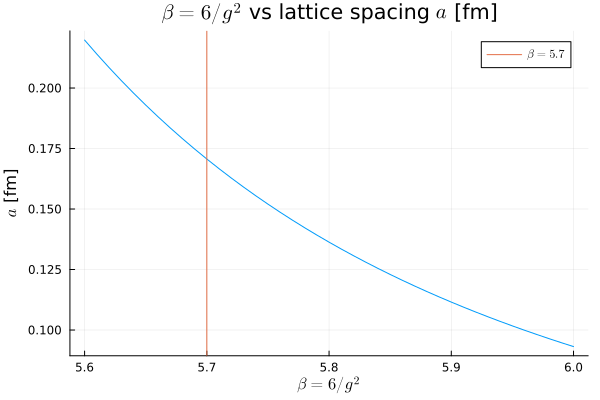

In [19]:
# beta と a の関数形をプロットしてみる。
betas = 5.6:0.01:6.0
abetas = a.(betas)
plot(betas,abetas,label=nothing,xlabel=raw"$\beta=6/g^2$",ylabel=raw"$a$ [fm]")
plot!(title=raw"$\beta = 6/g^2$ vs lattice spacing $a$ [fm]")
vline!([5.7], label=raw"$\beta=5.7$")

In [20]:
β = 5.7
println("a=$(a(β)) fm")

a=0.1706601237820899 fm


すると、カットオフは、$\hbar c = 197 $ MeV fm をつかうと

In [21]:
β = 5.7
a_inv = 197/a(β)
println("1/a=$(a_inv) MeV")

1/a=1154.341129223266 MeV


とわかります。これを$a m_\pi$にかければ良く、以下のようにわかります。

In [22]:
# LaTeXの文字列を組み立てる
pi_mass_str = L"今のセットアップで $\pi$中間子の質量はおよそ $m_{\pi} = $" * "$(round(m_pi * a_inv, digits=0))" * " MeV です。"

# Markdownを使って表示
display(Markdown.MD(pi_mass_str))

"今のセットアップで \$\\pi\$中間子の質量はおよそ \$m_{\\pi} = \$1489.0 MeV です。"


# まとめ

今回はLatticeQCD.jl でπ中間子の質量を計算しました。
得られた値は現実とは異なる値でした。解析に誤差を含めていないという点はおいて、
以下のような問題点や疑問点があります。

- Wilson fermion はカイラル対称性がないが、南部ゴールドストンボゾンであるπ中間子はどうなるのか。
- ホッピングパラメータκ (おおよそクォーク質量の逆数)は適切だったか
- カットオフはどうか (βの大きさ)。結果はそもそも連続極限を取っていない。
- クエンチ近似ではクォークの動的な効果を無視している

また、他のハドロンは質量などはどうだろうか? また今回無視した統計誤差はどうだろう?

現実の値に近づけるというのは一筋縄ではいかない (たとえば [参考](https://www2.ccs.tsukuba.ac.jp/PACS-CS/LQCD/results/kaisetsu.pdf) などを見てください)
のですが、この先はそれぞれ学んでください。